# Review of Statistics

This notebook shows some basic statistics needed for this course in financial econometrics. Details are in the first chapter of the lecture notes (pdf).

It uses the Statistics package (built in) for descriptive statistics (averages, autocorrelations, etc) and the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl)  package for statistical distributions (pdf, cdf, etc).  For more stat functions, see the StatsBase.jl package. (Not used here.)

## Load Packages and Extra Functions

In [1]:
using Printf, Statistics, DelimitedFiles, Distributions

include("jlFiles/printmat.jl")   #prettier matrix printing

printyellow (generic function with 1 method)

In [2]:
using Plots, LaTeXStrings         #packages for plotting and LaTeX

#pyplot(size=(600,400))           #use pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

# Distributions

## Probability Density Function (pdf)

The cells below calculate and plot some pdfs. The Distributions package has many more distributions.

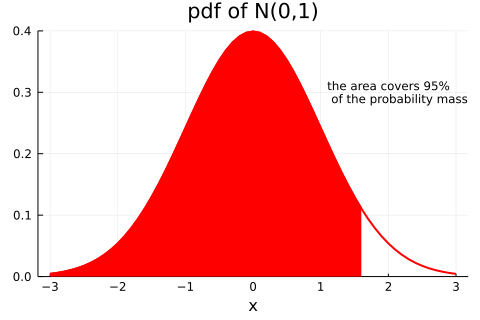

In [3]:
x  = -3:0.1:3
xb = x[x.<=1.645]                 #pick out x values <= 1.645

pdfx  = pdf.(Normal(0,1),x)       #calculate the pdf of a N(0,1) variable
pdfxb = pdf.(Normal(0,1),xb)

p1 = plot( x,pdfx,                        #plot pdf
           linecolor = :red,
           linewidth = 2,
           legend = nothing,
           ylims = (0,0.4),
           title = "pdf of N(0,1)",
           xlabel = "x",
           annotation = (1.1,0.3,text("the area covers 95%\n of the probability mass",:left,8)) )
plot!(xb,pdfxb,linecolor=:red,linewidth=2,legend=nothing,fill=(0,:red))    #plot area under pdf
display(p1)

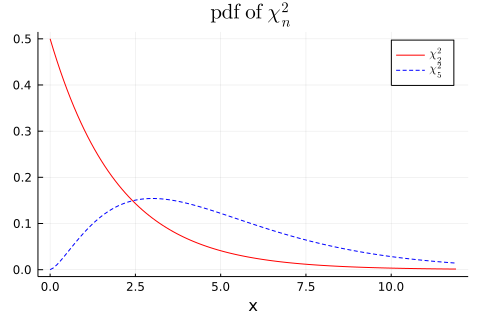

In [4]:
x  = 0.0001:0.1:12

pdf2  = pdf.(Chisq(2),x)         #pdf of Chisq(2)
pdf5 =  pdf.(Chisq(5),x)

p1 = plot( x,[pdf2 pdf5],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           label = [L"\chi_{2}^{2}" L"\chi_{5}^{2}"],
           title = L"\mathrm{pdf \ of \ } \chi_{n}^{2}",
           xlabel = "x" )
display(p1)

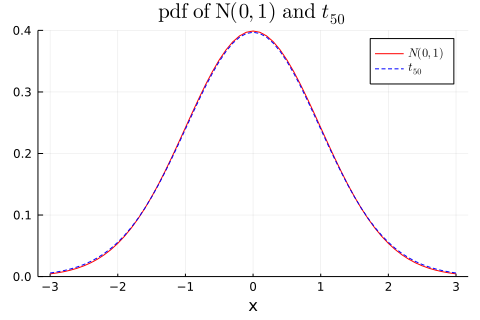

In [5]:
x  = -3:0.1:3

pdfN   = pdf.(Normal(0,1),x)
pdft50 = pdf.(TDist(50),x)            #pdf of t-dist with 50 df

p1 = plot( x,[pdfN pdft50],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           label = [L"N(0,1)" L"t_{50}"],
           ylims = (0,0.4),
           title = L"\mathrm{pdf \ of \ N(0,1) \ and \ } t_{50}",
           xlabel = "x" )
display(p1)

## Cumulative Distribution Function (cdf)

and probabilities for the random variable (here denoted $x$) to be below or at a value, for instance, cdf$(z)=$Pr$(x\leq z)$. 

Also, we can calculate Pr$(z \lt x)$ as $1-$cdf$(z)$ and Pr$(z_1 < x\leq z_2)$ as cdf$(z_2)-$cdf$(z_1)$.

Notice that Distributions package wants `Normal(μ,σ)`, where `σ` is the standard deviation. However, the notation in the lecture notes is $N(\mu,\sigma^2)$. For instance, $N(0,2)$ is coded as `Normal(0,sqrt(2))`.

In [6]:
printblue("Probability of:\n")
printlnPs("x<=-1.645 when x is N(0,1) ",cdf(Normal(0,1),-1.645))
printlnPs("x<=0 when x is N(0,1)      ",cdf(Normal(0,1),0))
printlnPs("2<x<=3 when x is N(0,2)    ",cdf(Normal(0,sqrt(2)),3)-cdf(Normal(0,sqrt(2)),2))
printlnPs("2<x<=3 when x is N(1,2)    ",cdf(Normal(1,sqrt(2)),3)-cdf(Normal(1,sqrt(2)),2))

printlnPs("\nx>4.61 when x is Chisq(2)  ",1-cdf(Chisq(2),4.61))
printlnPs("x>9.24 when x is Chisq(5)  ",1-cdf(Chisq(5),9.24))

Probability of:

x<=-1.645 when x is N(0,1)      0.050
x<=0 when x is N(0,1)           0.500
2<x<=3 when x is N(0,2)         0.062
2<x<=3 when x is N(1,2)         0.161

x>4.61 when x is Chisq(2)       0.100
x>9.24 when x is Chisq(5)       0.100


## Quantiles (percentiles)

...are just about inverting the cdf. For instance, the 5th percentile is the value $q$ such that cdf($q)=0.05$.

In [7]:
N05     = quantile(Normal(0,1),0.05)            #from the Distributions package
Chisq90 = quantile(Chisq(5),0.9)

printblue("\npercentiles:")
printlnPs("5th percentile of a N(0,1)       ",N05)
printlnPs("90th percentile of a Chisquare(5)",Chisq90)


percentiles:
5th percentile of a N(0,1)           -1.645
90th percentile of a Chisquare(5)     9.236


## Confidence Bands and t-tests

We have a point estimate equal to the value $b$ and it has a standar deviation of $\sigma$. The next few cells create a 90% confidence band around the point estimate (assuming it is normally distributed) and tests various null hypotheses.

In [8]:
b = 0.5                                         #an estimate (a random variable)
σ = 0.15                                        #std of the estimate. Do \sigma[Tab] to get σ
confB = [(b-1.64*σ) (b+1.64*σ)]                 #confidence band of the estimate

printlnPs("90% confidence band:",confB)
println("If the null hypothesis is outside this band, then it is rejected")

90% confidence band:     0.254     0.746
If the null hypothesis is outside this band, then it is rejected


In [9]:
tstat1 = (b - 0.4)/σ      #testing H₀: coefficient is 0.4
tstat2 = (b - 0.746)/σ    #testing H₀: coefficient is 0.746
tstat3 = (b - 1)/σ        #testing H₀: coefficient is 1.0

printblue("t-stats for different tests: are they beyond [-1.64,1.64]?\n")
rowNames = ["H₀: 0.4","H₀: 0.746","H₀: 1"]     #Do H\_0[TAB] to get H₀
printmat([tstat1;tstat2;tstat3];colNames=["t-stat"],rowNames)  #or rowNames=rowNames 

printred("compare with the confidence band")

t-stats for different tests: are they beyond [-1.64,1.64]?

             t-stat
H₀: 0.4       0.667
H₀: 0.746    -1.640
H₀: 1        -3.333

compare with the confidence band


## Load Data from a csv File

In [10]:
x = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)

                #yearmonth, market, small minus big, high minus low
(ym,Rme,RSMB,RHML) = [x[:,i] for i=1:4] 

println("Sample period: ",ym[1]," to ",ym[end])    #just numbers, not converted to Dates

Sample period: 197901.0 to 201104.0


## Means and Standard Deviations

In [11]:
xbar = mean([Rme RHML],dims=1)    #,dims=1 to calculate average along a column
σ    = std([Rme RHML],dims=1)
T    = length(Rme)

printmat([xbar;σ],colNames=["Rme","HML"],rowNames=["average","std"])

              Rme       HML
average     0.602     0.330
std         4.604     3.127



In [12]:
printblue("std of sample average (assuming iid data):\n")

printmat(σ/sqrt(T),colNames=["Rme","HML"],rowNames=["std(average)"])

std of sample average (assuming iid data):

                   Rme       HML
std(average)     0.234     0.159



## Skewness, Kurtosis and Bera-Jarque

In [13]:
xStd     = (Rme .- mean(Rme))./std(Rme)
skewness = mean(xStd.^3)
kurtosis = mean(xStd.^4)

BJ     = (T/6)*skewness.^2 + (T/24)*(kurtosis.-3).^2  #Chisq(2)
pvalBJ = 1 .- cdf.(Chisq(2),BJ)

printblue("Testing skewness and kurtosis:\n")
printmat([skewness,kurtosis,BJ],colNames=["Rme"],rowNames=["Skewness","Kurtosis","Bera-Jarque"])

Testing skewness and kurtosis:

                  Rme
Skewness       -0.806
Kurtosis        5.347
Bera-Jarque   131.128



## Covariances and Correlations

In [14]:
println("\ncov([Rme RHML]): ")
printmat(cov([Rme RHML]))

println("\ncor([Rme RHML]): ")
printmat(cor([Rme RHML]))

ρ = cor(Rme,RHML)
tstat = sqrt(T)*ρ/sqrt(1-ρ^2)

printlnPs("correlation and its t-stat:",ρ,tstat)


cov([Rme RHML]): 
    21.197    -4.875
    -4.875     9.775


cor([Rme RHML]): 
     1.000    -0.339
    -0.339     1.000

correlation and its t-stat:    -0.339    -7.090
